# Webscraping and Salary Prediction Project

The purpose of this project was to webscrape job listing information from Indeed and then run a model to predict if the salary would be HIGH or LOW. 

The below was the brief set for the project. My solution follows the brief. 

### Directive

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### My Results

Our task was to scrape job information from Indeed across varying markets to try and predict whether a job would be classified as high salary or low salary. The Decision Tree Ensemble method was our most successful model achieving an accuracy score of 0.899% with strong generalization. 

#### Data Collection

In order to gather our data, I built a custom webscraper to gather data from Indeed. We leveraged this data set for the modelling. 

#### Data Cleaning

For the purpose of this task, we were only able to use data that had salary information in a yearly format. As such, we removed any rows with no salary information or salary information that was not yearly. Next, we turned the salary information into a integer that we could use for processing. In the instances where there was a salary range, we took the mean. 

After successfully cleaning the data, we turned our salary information into a target variable. As this was a classification problem, we wanted a threshold to determine if a salary was HIGH or LOW. To achieve this, we used the median salary of the entire data set. Our target variable was now a binary variable that was 1 of the salary of a specific job post was over the median, or 0 if it was below. 

With our data all ready to go, we were ready to undertake some feature engineering. 

#### Feature Engineering

As a lot of our data was in text format, we took advantage of the TF-IDF method in Natural Language Processing. This method quantifies words in a document or corpus of text providing. This quantification allows us to feed this information into a classification model. We chose to leverage this method on the 'Location' data that we had available. 

In addition to applying TF-IDF to the 'Location' data, we generated key word features that looked through the 'Title' and 'Summary' of a job post and indicated if these contained any words that could indicate a higher paying job. For example in the title, we focused on words such as 'Senior', 'Manager' and 'Executive' as these are all titles held by individuals later in their career and could indicate a higher salary. These additional features proved valuable as running the model on just the 'Location' data yielded a lower score. 

#### Results

Using the bagging method combined with a Decision Tree as the base estimator, we were able to achieve an accuracy of almost 90% with a strong level of generalization. This means our model does well on unseen data so would work as expected if we put it into production. Also, if the team is concerned about predicting a high salary when it ultimately isn't one, we can easily adjust our threshold and build this concern into our model. This will lead to more incorrect Low Salary predictions, but it will lower the instances where we predict a High Salary and it turns out to be a Low Salary. 

#### Risk & Limitations

- Not all jobs had salary information, so we risk running our model on a subset of the types of jobs. 
- Our data also only focuses on the UK Data job market. So any predictions outside this scope is not advised. 

In [1]:
# importing all the necessary packages
import requests
import bs4
from bs4 import BeautifulSoup
import numpy as np
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, plot_confusion_matrix, recall_score, precision_recall_curve, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt

### __1) Data Gathering and Cleaning__

In order to webscrape the data from Indeed, I built some helper functions and leveraged them to iteratively collect data.

In [2]:
def extract_data(job, div):

    try:
        job['title'] = div.find('div', attrs = {'class': 'heading4 color-text-primary singleLineTitle tapItem-gutter'}).text.strip()
    except:
        job['title'] = np.nan

    try:
        job['companyName'] = div.find('span', attrs = {'class' : 'companyName'}).text.strip()
    except:
        job['companyName'] = np.nan

    try:
        job['rating'] = div.find('span', attrs = {'class': 'ratingsDisplay withRatingLink'}).text.strip()
    except:
        job['rating'] = np.nan

    try:
        job['location'] = div.find('div', attrs = {'class':'companyLocation'}).text.strip()
    except:
        job['location'] = np.nan

    try:
        job['summary'] = div.find('div', attrs = {'class':'job-snippet'}).text.strip()
    except:
        job['summary'] = np.nan

    try:
        job['salary'] = div.find('span', attrs = {'class':'salary-snippet'}).text.strip()
    except:
        job['salary'] = np.nan

    return job

In [ ]:
# Sample code of how indeed was scraped. The JSON was saved down as a csv file that we read in the next section. 

url_template = "http://www.indeed.co.uk/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_pages_per_city = 700 # Set this to a high-value (5000) to generate more results. 

results = []

for city in set(['Bath', 'Belfast', 'Birmingham', 'Bristol', 'Cambridge', 'Cardiff', 'Edinburgh', 'Exeter', 'Glasgow', 'Leeds', 'Liverpool', 'London', 'Manchester', 'Newcastle', 'Oxford']):
    for start in range(0, max_pages_per_city*10, 10):
        url = url_template.format(city, start)
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')

        for div in soup.find_all('div', attrs = {'class': 'job_seen_beacon'}): # taking every single jop posting tile and iterating through them
            job = dict() # creating a dictionary of all the job information that will be iteratively updated
            job = extract_data(job, div) # calling the exctract data function to extrace required data from a single job posting
            results.append(job)

# saving all our data into a JSON that can easly be imported into a Pandas Dataframe

with open('indeed_data.json', 'w') as file: 
    json.dump(results, file, sort_keys=True)
    

The above code snipet outlines how we scraped indeed. This process took a long time as the Indeed website blocked my IP Address so I had to re-route and mask myself using VPNs. This process resulted in a file that was saved down as a CSV that we are going to load here and move forward with. 

In [18]:
df = pd.read_csv('fr_raw_data_jobs_uk.csv')

In [19]:
df.head()

,Unnamed: 0,Location,Title,Company,Salary,Description,City,jobs
0,0,NaN,Business Intelligence Analyst,Dynamic Planner,"£32,000 - £40,000 a year","Provision of accurate, accessible, and impactf...",Exeter,business+intelligence
1,1,NaN,Senior HR Advisor *Based in the South West* Pe...,Sitel,"£26,000 - £28,000 a year",We offer benefits to keep you healthy and happ...,Exeter,business+intelligence
2,2,NaN,Business Development Executive,Sigma Software Distribution,"£18,500 a year",Generate new business sales and opportunities:...,Exeter,business+intelligence
3,3,NaN,French Customer Service Advisor based in Exete...,Sitel,£10.50 an hour,We offer benefits to keep you healthy and happ...,Exeter,business+intelligence
4,4,NaN,German Customer Service Adviser based in Exete...,Sitel,£10.50 an hour,We offer benefits to keep you healthy and happ...,Exeter,business+intelligence


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83389 entries, 0 to 83388
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   83389 non-null  int64 
 1   Location     75072 non-null  object
 2   Title        83389 non-null  object
 3   Company      83388 non-null  object
 4   Salary       34923 non-null  object
 5   Description  83389 non-null  object
 6   City         83389 non-null  object
 7   jobs         83389 non-null  object
dtypes: int64(1), object(7)
memory usage: 5.1+ MB


The next step required data cleaning and turning the salary information into a binary target variable

To clean up the data: 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
2. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
3. Some of the entries may be duplicated.
4. The salaries are given as text and usually with ranges.



In [21]:
# dropping all rows where salar is NaN
df = df[df['Salary'].notna()]

# Pull out all those that are only yearly
df = df[df.Salary.str.contains('year')]

# Checking for duplicates
df = df[~df.duplicated()].reset_index(drop=True)

# Salary function and applying it to our salary column. Had to make a small change to use GBP instead of USD
def salary(salary_string):
    numbers = []
    for item in salary_string.split():
        item = item.replace(',', '')
        item = item.replace('£', '')
        if item.isdigit():
            item = int(item)
            numbers.append(item)
    return np.mean(numbers)

df.Salary = df.Salary.map(salary)

# let us also drop the null values for location
df = df[df['Location'].notna()]

df.drop('Unnamed: 0', inplace=True, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27017 entries, 5 to 31093
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Location     27017 non-null  object 
 1   Title        27017 non-null  object 
 2   Company      27017 non-null  object 
 3   Salary       27017 non-null  float64
 4   Description  27017 non-null  object 
 5   City         27017 non-null  object 
 6   jobs         27017 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.6+ MB


Now that we have a cleaned data set we can create the target variable used for prediction. I will be predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. I chose the median as the splitting point, but we can do many different splitting points if we'd like


In [22]:
# Creating a new column that shows 1 if salary is above median, and 0 if below. So, HIGH = 1, LOW = 0
median = df.Salary.median()

df['Salary_Class'] = df.Salary.map(lambda x: 1 if x > median else 0)

# The baseline for this code is 50%. This is the result we would get if we guessed LOW for each item (i.e. pure chance)
df.Salary_Class.value_counts(normalize=True)

0    0.500463
1    0.499537
Name: Salary_Class, dtype: float64

In [23]:
df.reset_index(drop=True, inplace=True)

### __2) Feature Engineering and Dummification__

Now that we have our input data ready, let us begin modelling. We will be using a logistic regression and decision tree to try and predict HIGH vs LOW. Additionally, we are also going to do some feature engineering. 

In [26]:
# Let us create a new column that indicates if there is a key word in the title description that could indicate a high salary
def word_match_title(string):
    words_title = ['senior', 'officer', 'executive', 'manager', 'director']
    count = 0
    for char in string.split():
        if char.lower() in words_title:
            count+=1
    if count > 0:
        return 1
    else:
        return 0

df['key_word_title'] = df.Title.map(lambda x: word_match_title(x))

# Now let us create a feature that indicates if certain words that could indicate a higher salary are in the description of the job
def word_match_description(string):
    description_words = ['growth', 'independent', 'high-paced', 'experienced', 'leader']
    count = 0
    for char in string.split():
        if char.lower() in description_words:
            count+=1
    if count > 0:
        return 1
    else:
        return 0

df['key_word_description'] = df.Description.map(lambda x: word_match_description(x))

df.head()

,Location,Title,Company,Salary,Description,City,jobs,Salary_Class,key_word_title,key_word_description
0,Exeter,Graduate Operational Management Programme,South West Water,25000.0,"Joining us on a full-time, permanent basis, yo...",Exeter,business+intelligence,0,0,0
1,Exeter EX2 7HR,Graduate Operational Management Programme,Graduate,25000.0,"Joining us on a full-time, permanent basis, yo...",Exeter,business+intelligence,0,0,0
2,Exeter,Junior Project Manager,OfficeLabs,31500.0,OfficeLabs are an information management & tec...,Exeter,business+intelligence,0,1,0
3,Exeter,Business Development Manager,YTKO Ltd,51000.0,Business development: 4 years (Preferred).\nYo...,Exeter,business+intelligence,1,1,0
4,Buckfastleigh,Chief Executive,Go Beyond Charity,57500.0,Excellent communicator with high degree of emo...,Exeter,business+intelligence,1,1,0


In [27]:
# Now, let us create our new dataframe with only the columns that we want
df2 = df[['Location','jobs','key_word_title','key_word_description']]
target = df['Salary_Class']

X_train, X_test, y_train, y_test = train_test_split(df2, target, test_size = 0.2)

# Now, let us dummify the City and jobs variables.
X_train = pd.get_dummies(X_train, columns=['jobs'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['jobs'], drop_first=True)

# Vectorizing the location data
tvec = TfidfVectorizer(norm='l2', stop_words='english', max_features=10000)
tvec.fit(X_train['Location'])

location_vectorized_2 = pd.DataFrame(tvec.transform(X_train.Location).toarray(), columns=tvec.get_feature_names())
location_vectorized_test_2 = pd.DataFrame(tvec.transform(X_test.Location).toarray(), columns=tvec.get_feature_names())

X_train = pd.concat([X_train.reset_index(drop=True), location_vectorized_2], axis=1).drop('Location', axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), location_vectorized_test_2], axis=1).drop('Location', axis=1)

# checking shapes
print('This is the shape for our X train: {}'.format(X_train.shape))
print('This is the shape for our X test: {}'.format(X_test.shape))
print('This is the shape for our y train: {}'.format(y_train.shape))
print('This is the shape for our y test: {}'.format(y_test.shape))

This is the shape for our X train: (21613, 1090)
This is the shape for our X test: (5404, 1090)
This is the shape for our y train: (21613,)
This is the shape for our y test: (5404,)


### __3) Modelling__

Logistic Regression with GridSearch

In [28]:
lr = LogisticRegression()
params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear'],
                   'C': np.logspace(-4, 4, 9)}
gs = GridSearchCV(lr, params, cv=5, n_jobs=2, verbose=1)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [31]:
best_lr = gs.best_estimator_
print('These are the best parameters: {}'.format(gs.best_params_))
print('This is the best score: {}'.format(gs.best_score_))
print('This is the test score: {}'.format(gs.score(X_test, y_test)))

These are the best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
This is the best score: 0.8150649491334996
This is the test score: 0.8073649148778682


Decision Tree Ensemble Model with GridSearch

In [30]:
tree = DecisionTreeClassifier()
bagging = BaggingClassifier(base_estimator=tree)
params = {'n_estimators': [15, 20, 25, 30], 'max_features': [0.5],'max_samples': [0.5] }
gs_2 = GridSearchCV(bagging, params, cv=5, n_jobs=2, verbose=1)

gs_2.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=2,
             param_grid={'max_features': [0.5], 'max_samples': [0.5],
                         'n_estimators': [15, 20, 25, 30]},
             verbose=1)

In [33]:
best_dt = gs_2.best_estimator_
print('This is the training score: {}'.format(gs_2.score(X_train, y_train)))
print('This is the testing score: {}'.format(gs_2.score(X_test, y_test)))

This is the training score: 0.884051265442095
This is the testing score: 0.8630643967431533


The decision tree ensemble method was cleary the best performing model of the two I tried

### __4) Model Evaluation__

My (fictitious) boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Luckily for him, we can easily adjust the threshold of what our model predicts!

In addition to this, I will also use the below methods for evaluation

- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

#### Adjusting Threshold

In order to ease the mind of our boss, we can simply leverage our model to predict the probability of a high salary and then determine our own threshold. For example, if we set a threshold of 0.75, only the values that our model believes have a higher than 75% of being a high salary will be labelled as high salary. 

If we increase our threshold, we will consistenly be increasing the precision of our model. This means, the ones that we predict to be high salary will most likely actually result in a high salary. We can get a precision of 1 if we really want to by just continuously increasing our threshold. However, this comes at a cost. Increasing the threshold will at some point reduce the accuracy of our model and lead to incorrect predicitons. It will also reduce our recall and the F1-Score

In order to ease his mind, we can just run the below code on any prediction that a model generates.

In [35]:
def threshold_manual(x, threshold = 0.5):
    if x >= threshold:
        return 1
    else:
        return 0

predict_prob = pd.DataFrame(best_lr.predict_proba(X_test), columns=['Low_Salary_PP', 'High_Salary_PP'])
predict_class = predict_prob.High_Salary_PP.apply(threshold_manual, threshold=0.75) # adjust the threshold how you'd like

#### Classification Reports to see Accuracy, Precision, and Recall

In [36]:
lr_predict = best_lr.predict(X_test)
dt_predict = best_dt.predict(X_test)

print(classification_report(y_test, lr_predict, digits=4))
print(classification_report(y_test, dt_predict, digits=4))

print('This is the AUC score for the Logistic Regression Model: {}'.format(roc_auc_score(y_test, lr_predict)))
print('This is the AUC score for the Decision Tree Model: {}'.format(roc_auc_score(y_test, dt_predict)))

              precision    recall  f1-score   support

           0     0.8393    0.7660    0.8010      2735
           1     0.7799    0.8498    0.8133      2669

    accuracy                         0.8074      5404
   macro avg     0.8096    0.8079    0.8072      5404
weighted avg     0.8100    0.8074    0.8071      5404

              precision    recall  f1-score   support

           0     0.9090    0.8106    0.8570      2735
           1     0.8253    0.9168    0.8687      2669

    accuracy                         0.8631      5404
   macro avg     0.8671    0.8637    0.8628      5404
weighted avg     0.8676    0.8631    0.8627      5404

This is the AUC score for the Logistic Regression Model: 0.807876403393831
This is the AUC score for the Decision Tree Model: 0.8637130353719289


#### Precision Recall and ROC Curve for our Decision Tree Model

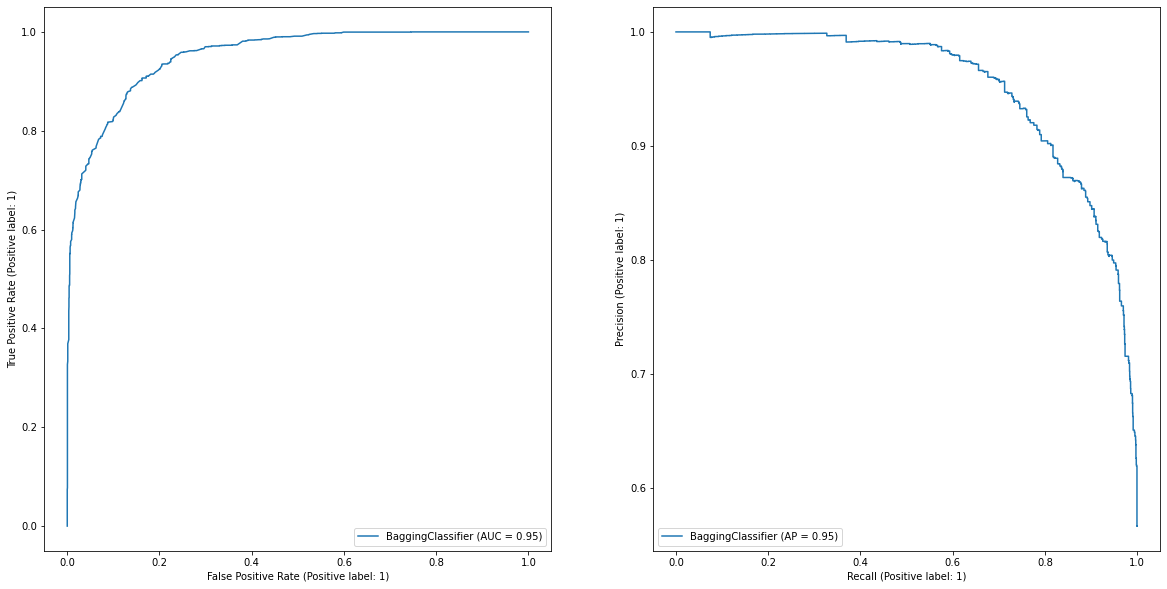

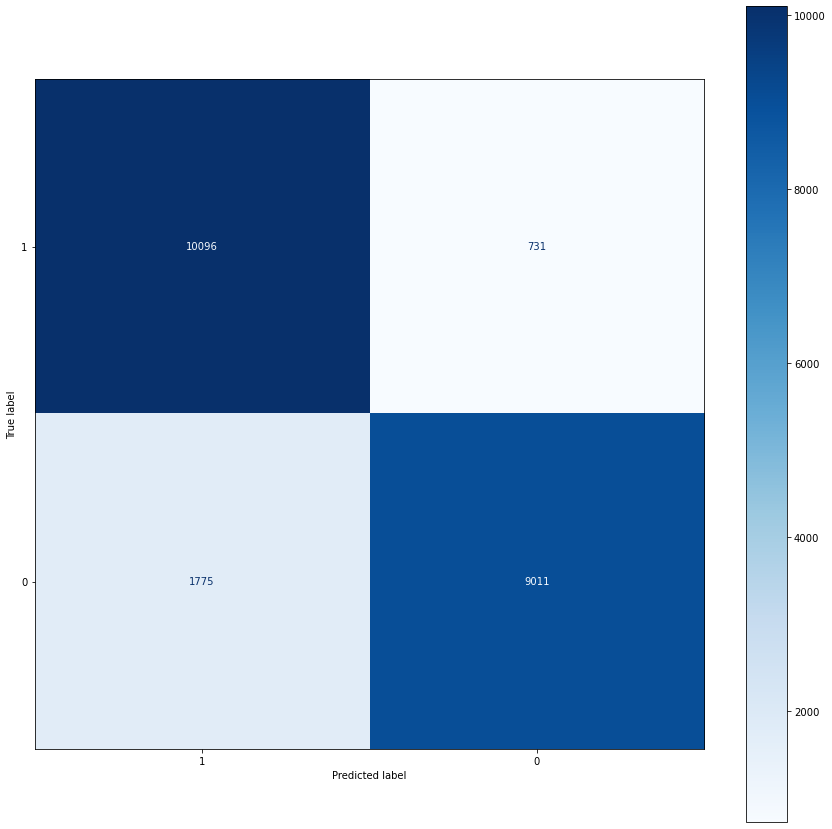

In [37]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(20, 10))
plot_roc_curve(best_dt, X_test, y_test, ax=ax[0])
plot_precision_recall_curve(best_dt, X_test, y_test, ax=ax[1])
plt.show()

fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(best_dt, X_train, y_train, cmap='Blues', labels=[1, 0], values_format='.0f', ax=ax)
plt.show()